## Setup

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.spatial import KDTree # 导入我们需要的KDTree

import pyvista as pv
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union

import cadquery as cq
from cadquery.vis import show

pv.set_jupyter_backend('trame')

In [19]:
project_path = "E:/HFSS/projects/patch1.aedt"
output_dir = "E:/HFSS/temp/aedt_ml_data/"

design_name = "HFSSDesign1"
setup_name = "Setup1"
file_name = "geometry.step"

geometry_path = os.path.join(output_dir, file_name)
s_param_path = os.path.join(output_dir, "s_parameters.csv")
mesh_csv_path = os.path.join(output_dir, "mesh_data.csv")
fld_path = os.path.join(output_dir, "surface_field_export.fld")
stl_path = os.path.join(output_dir, "output_mesh.stl")

## Define constants

In [4]:
H = 1.6
L0 = 28
W0 = 37.26
L1 = 17.45
W1 = 1
L2 = 15
W2 = 2.98

In [5]:
substrate_origin    = [-L0, -W0, 0]
substrate_size      = [1.5*L0+L1+L2, 2*W0, H]
substrate_material  = 'FR4_epoxy'

In [6]:
air_origin    = [-L0*0.5-30, -W0*0.5-30, 0]
air_size      = [L0+L1+L2+30, W0+60, H+30]
air_mateiral  = 'vacuum'

In [7]:
tline_origin       = [0.5*L0, -0.5*W1, H]
tline_size         = [L1, W1]
tline_orientation  = 'xy'

patch_origin       = [-0.5*L0, -0.5*W0, H]
patch_size         = [L0, W0]
patch_orientation  = 'xy'

ohm50_origin       = [0.5*L0+L1, -0.5*W2, H]
ohm50_size         = [L2, W2]
ohm50_orientation  = 'xy'

wave_port_origin   = [0.5*L0+L1+L2, -4*W2, 0]
wave_port_size     = [8*W2, 8*H]
wave_port_orientation = 'yz'

In [8]:
# Convert all dimensions to meters (m) for consistency with Ansys export
H, L0, W0, L1, W1, L2, W2 = [d / 1000.0 for d in [H, L0, W0, L1, W1, L2, W2]]

# List of geometric objects defining the model's footprint
hfss_objects = [
    {'origin': [0.5 * L0, -0.5 * W1, H], 'size': [L1, W1]},
    {'origin': [-0.5 * L0, -0.5 * W0, H], 'size': [L0, W0]},
    {'origin': [0.5 * L0 + L1, -0.5 * W2, H], 'size': [L2, W2]}
]

## Plot 3D Model

In [9]:
imported_model = cq.importers.importStep(geometry_path)
imported_model

## Plot S-Parameters

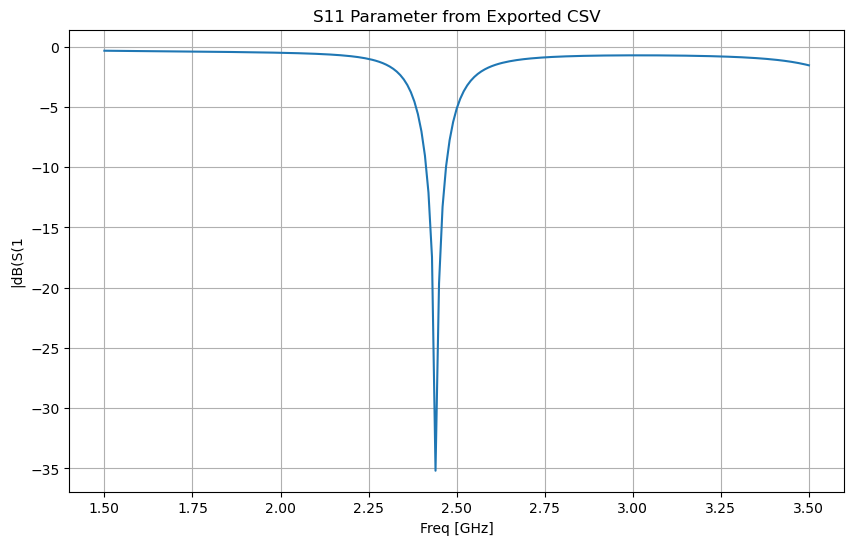

In [10]:
s_param_df = pd.read_csv(s_param_path)

plt.figure(figsize=(10, 6))
plt.plot(s_param_df.iloc[:, 7], s_param_df.iloc[:, 8])
plt.title('S11 Parameter from Exported CSV')
plt.xlabel(s_param_df.columns[7])
plt.ylabel(s_param_df.columns[8])
plt.grid(True)
plt.show()

## Plot and Save Mesh

Processes a 2D mesh point cloud exported from Ansys HFSS, cleans geometric artifacts by filtering against a precise, user-defined boundary, and provides functions for 3D visualization and STL file export.

In [11]:
def create_boundary_from_corners(objects):
    """
    Creates a unified Shapely polygon from a list of rectangle definitions.

    Args:
        objects (list): A list of dictionaries, where each dictionary defines a
                        rectangle with 'origin' (bottom-left corner) and
                        'size' (length, width).

    Returns:
        shapely.geometry.BaseGeometry: A single Polygon or MultiPolygon object
                                       representing the union of all rectangles.
    """
    polygons = []
    for obj in objects:
        # Assumes 'origin' is the bottom-left corner of the rectangle
        x_start, y_start = obj['origin'][0], obj['origin'][1]
        length, width = obj['size'][0], obj['size'][1]
        
        # Calculate the four corner points of the rectangle
        p1 = (x_start, y_start)
        p2 = (x_start + length, y_start)
        p3 = (x_start + length, y_start + width)
        p4 = (x_start, y_start + width)
        polygons.append(Polygon([p1, p2, p3, p4]))
        
    return unary_union(polygons)


In [12]:
data_start_line = 0
with open(fld_path, 'r') as f:
    for i, line in enumerate(f):
        if line.strip() and (line.strip()[0].isdigit() or line.strip().startswith('-')):
            data_start_line = i
            break

In [13]:
df = pd.read_csv(
    fld_path,
    header=None,       
    skiprows=data_start_line, 
    sep=' ',
    names=['X', 'Y', 'Z', 'Mag_E']
)
df

,X,Y,Z,Mag_E
0,0.046450,-0.000544,0.0016,3124.919792
1,0.045475,-0.001017,0.0016,3664.890869
2,0.046450,-0.000036,0.0016,2914.127572
3,0.044499,-0.001490,0.0016,7355.145362
4,0.045475,-0.000509,0.0016,3422.815186
...,...,...,...,...
3799,0.010870,-0.013592,0.0016,1632.504342
3800,0.009722,-0.013694,0.0016,1366.640747
3801,0.011409,-0.014454,0.0016,1880.900829
3802,0.010261,-0.014556,0.0016,1636.408936


In [14]:
points = df[['X', 'Y', 'Z']].values
field_values = df['Mag_E'].values

cloud = pv.PolyData(points)
cloud['field_value'] = field_values

initial_mesh = cloud.delaunay_2d()
model_boundary = create_boundary_from_corners(hfss_objects)

 Filter Mesh based on Geometric Boundary 

In [15]:
good_cells_list = []
points_array = initial_mesh.points
faces_flat_array = initial_mesh.faces
i = 0
while i < len(faces_flat_array):
    num_points_in_cell = faces_flat_array[i]
    if num_points_in_cell == 3:
        p_indices = faces_flat_array[i + 1 : i + 4]
        centroid = np.mean(points_array[p_indices], axis=0)
        
        # Keep cell only if its centroid is inside the true boundary
        if model_boundary.contains(Point(centroid[0], centroid[1])):
            good_cells_list.append(faces_flat_array[i : i + 4])
    i += num_points_in_cell + 1

if not good_cells_list:
    raise RuntimeError("No cells were found inside the defined boundary.")

Reconstruct Final Mesh and Map Data

In [17]:
new_faces_array = np.array(good_cells_list).flatten()
clean_mesh = pv.PolyData(initial_mesh.points, faces=new_faces_array)
clean_mesh = clean_mesh.extract_largest()

# Use KDTree to correctly map scalar values from the original cloud
kdtree = KDTree(cloud.points)
distances, closest_points_indices = kdtree.query(clean_mesh.points)
clean_mesh['field_value'] = cloud['field_value'][closest_points_indices]
mesh = clean_mesh

### Final Plot and Save

In [20]:
# Save the clean mesh to a file
mesh.save(stl_path)

# Plot the mesh
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(mesh, color='lightblue', show_edges=True)
plotter.show_axes()
plotter.show()

Widget(value='<iframe src="http://localhost:2789/index.html?ui=P_0x26f15798fb0_0&reconnect=auto" class="pyvist…

## Plot E Field

In [26]:
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(
        mesh, 
        scalars='field_value', 
        cmap='viridis', 
        show_edges=True,
        scalar_bar_args={'title': 'Mag_E (V/m)'}
    )
plotter.show_axes()
plotter.show()

Widget(value='<iframe src="http://localhost:2789/index.html?ui=P_0x26f179a5610_6&reconnect=auto" class="pyvist…